# Part One: Training Phase

In this part we prepare the dataset and train our models with Three approaches and save the trained models then we analyze the results.

In [1]:
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
# import tensorflow_addons as tfa

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

In [2]:
directory = '/kaggle/input/moones-hda/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
batch_size = 32
img_height = 256
img_width = 256
NUM_CHANNELS = 3

Here we implemented some data preprocessing and data augmentation techniques such as rescaling, zero padding and cropping.

In [3]:
def train_data_augmentation(image, label):
    image = tf.cast(image, tf.float32) / 255.
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    image = tf.image.resize_with_crop_or_pad(image, img_height, img_width)
    return image, label

# def rotation_augmentation(image, label):
#     random_degree = tf.random.uniform(shape=[], minval=-45, maxval=45)
#     image = tfa.image.rotate(image, random_degree * (math.pi/180.))
#     return image, label

def test_data_augmentation(image, label):
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, [img_height, img_width])
    return image, label

Then we create train and test dataset objects with map, cache and prefetch techniques.

In [4]:
def create_dataset(directory, batch_size):
    train_ds = tf.keras.utils.image_dataset_from_directory(directory,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        validation_split=0.2,
        subset='training',
        crop_to_aspect_ratio=False)

    test_ds = tf.keras.utils.image_dataset_from_directory(directory,
      labels='inferred',
      label_mode='categorical',
      color_mode='rgb',
      batch_size=batch_size,
      seed=42,
      validation_split=0.2,
      subset='validation',
      crop_to_aspect_ratio=False)

#     train_ds = train_ds.map(rotation_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_ds = train_ds.map(train_data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_ds = train_ds.cache()
    train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

    test_ds = test_ds.map(test_data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.cache()
    test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return train_ds, test_ds

In [5]:
train_ds, test_ds = create_dataset(directory, batch_size)

Found 4575 files belonging to 3 classes.
Using 3660 files for training.
Found 4575 files belonging to 3 classes.
Using 915 files for validation.


This function plot some of images and labels.

In [6]:
def plot_image(X_input, labels):
    plt.imshow(X_input, cmap=plt.cm.gray_r, interpolation='nearest')
    print("LABEL: %s" % labels)
    plt.show()
    return

def label_decoder(label):
    if label[0] == 1:
        return 'Covid'
    if label[1] == 1:
        return 'Normal'
    if label[2] == 1:
        return 'Pneumonia'

LABEL: Normal


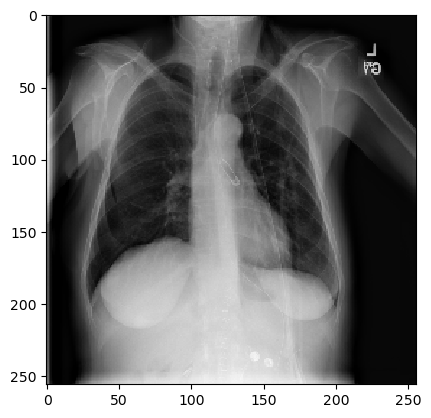

LABEL: Covid


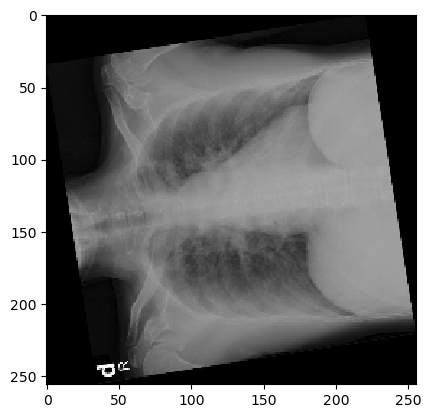

LABEL: Normal


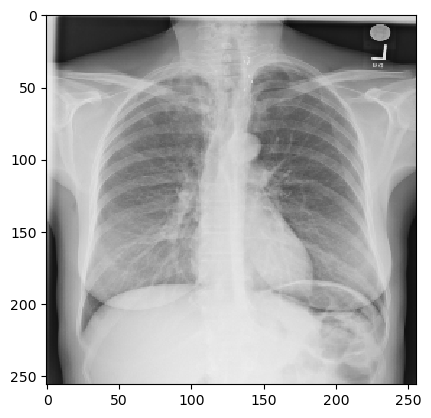

LABEL: Covid


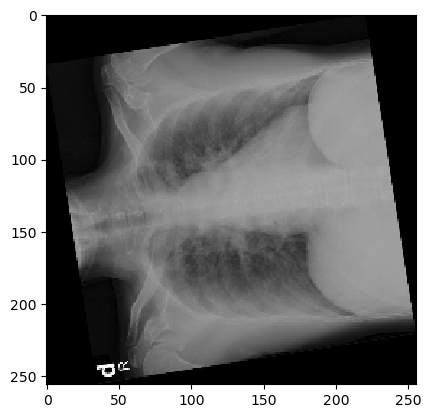

LABEL: Covid


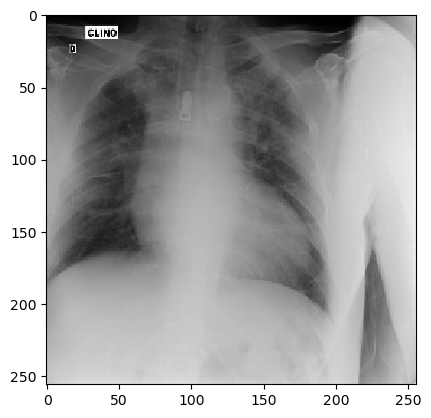

In [7]:
indices = np.random.randint(0, 32, (5,))
ds = train_ds.take(1).get_single_element()
for index in indices:
    image = ds[0][index]
    label = label_decoder(ds[1][index])
    plot_image(image, label)

And here we defined train and validation steps and some functions to handle plotting the curves, saving histories and calculating some metrics for evaluation.

In [8]:
train_steps = int(tf.data.experimental.cardinality(train_ds).numpy())

test_steps = int(tf.data.experimental.cardinality(test_ds).numpy())

In [9]:
def create_history_df(df_name, history):
    df = pd.DataFrame(history.history)
    df.to_csv(df_name)
    return df

In [10]:
def plot_loss_acc(history, save=True):
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    if save:
        plt.savefig('accuracy_plot' + '.jpg', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    if save:
        plt.savefig('loss_plot' + '.jpg', dpi=500, bbox_inches = 'tight')
    plt.show()

In [11]:
def calculate_p_r_f1(model):
    y_test_preds = model.predict(test_ds)
    y_test_preds = np.argmax(y_test_preds, axis=1)
    y_test = np.concatenate([y for x, y in test_ds], axis=0)
    y_test = y_test.argmax(axis=1)
    # Compute precision, recall, fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_test_preds, average=None)
    return precision, recall, fscore

def confusion_matrix_report(model, report_file_name):
    y_test_preds = model.predict(test_ds)
    y_test_preds = np.argmax(y_test_preds, axis=1)
    y_test = np.concatenate([y for x, y in test_ds], axis=0)
    y_test = y_test.argmax(axis=1)
    
    report = classification_report(y_test, y_test_preds, target_names=['covid', 'normal', 'pneumonia'])
    
    def report_to_df(report):
        report = [x.split(' ') for x in report.split('\n')]
        header = ['Class Name']+[x for x in report[0] if x!='']
        values = []
        for row in report[1:-5]:
            row = [value for value in row if value!='']
            if row!=[]:
                values.append(row)
        df = pd.DataFrame(data = values, columns = header)
        return df
    report_df = report_to_df(report)
    
    report_df.to_csv(report_file_name, index=True)
    return report

def plot_confusion_matrix(model, classes, file_name='confusion_matrix' ,save= True,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):

    y_test_preds = model.predict(test_ds)
    y_test_preds = np.argmax(y_test_preds, axis=1)
    y_test = np.concatenate([y for x, y in test_ds], axis=0)
    y_test = y_test.argmax(axis=1)
    
    cm = confusion_matrix(y_test, y_test_preds)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()
    
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '14'
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save:
        plt.savefig(file_name + '.jpg', dpi=500, bbox_inches = 'tight')

# Shallow model

In [12]:
class ShallowClassifier:
    def __init__(self, activation):
        self.activation = activation

    def __conv_pool(self, X, output_channels=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same',
                    pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same'):
        X = tf.keras.layers.Conv2D(output_channels, conv_kernel, strides=conv_strides, padding=conv_padding,
                                   activation=None)(X)
        X = tf.keras.layers.BatchNormalization(axis=3)(X)
        X = tf.keras.layers.Activation(self.activation)(X)
        return tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    def __Shallow(self, input_shape):
        X_input = tf.keras.Input(input_shape)

        X = self.__conv_pool(X_input, output_channels=8, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same',
                             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='valid')

        X = self.__conv_pool(X, output_channels=16, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same',
                             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='valid')

        X = self.__conv_pool(X, output_channels=32, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same',
                             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='valid')

        X = self.__conv_pool(X, output_channels=64, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same',
                             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='valid')

        return tf.keras.Model(inputs=X_input, outputs=X, name='Shallow-model')

    def create_model(self, input_shape, num_classes):
        base_model = self.__Shallow(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dense(16, activation=self.activation)(fc)
        fc = tf.keras.layers.Dropout(0.2)(fc)
        fc = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='Shallow-Classifier')

In [13]:
model = ShallowClassifier(activation='relu').create_model(input_shape=(img_height, img_width, NUM_CHANNELS), num_classes=3)

In [14]:
model.summary()

Model: "Shallow-Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_shallow.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy'])

In [16]:
shallow_history = model.fit(train_ds, epochs = 50, validation_data=test_ds, callbacks=[checkpoint, early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.8128
Epoch 1: val_accuracy improved from -inf to 0.32678, saving model to best_model_shallow.h5
115/115 [==============================] - 70s 510ms/step - loss: 0.5203 - accuracy: 0.8128 - val_loss: 1.1868 - val_accuracy: 0.3268
Epoch 2/50
113/115 [============================>.] - ETA: 0s - loss: 0.3378 - accuracy: 0.8836
Epoch 2: val_accuracy improved from 0.32678 to 0.36831, saving model to best_model_shallow.h5
115/115 [==============================] - 4s 33ms/step - loss: 0.3377 - accuracy: 0.8831 - val_loss: 1.1762 - val_accuracy: 0.3683
Epoch 3/50
113/115 [============================>.] - ETA: 0s - loss: 0.2894 - accuracy: 0.9013
Epoch 3: val_accuracy improved from 0.36831 to 0.64044, saving model to best_model_shallow.h5
115/115 [==============================] - 4s 33ms/step - loss: 0.2888 - accuracy: 0.9016 - val_loss: 0.7765 - val_accuracy: 0.6404
Epoch 4/50
113/115 [===============

In [17]:
shallow_df = create_history_df('shallow_history.csv', shallow_history)

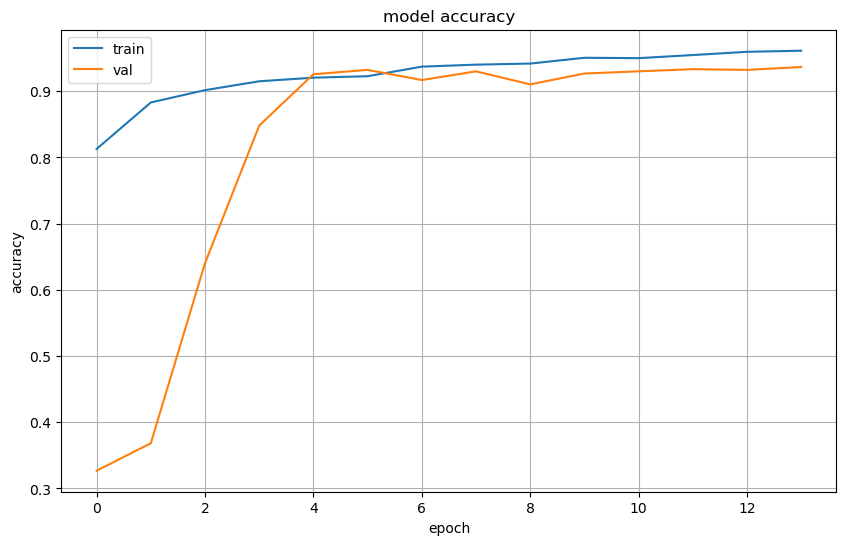

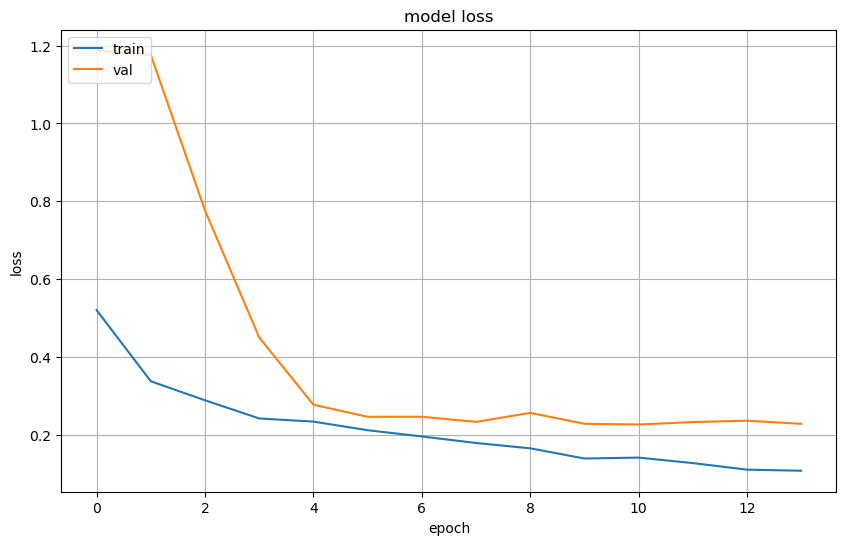

In [18]:
plot_loss_acc(shallow_history)

In [19]:
precision, recall, fscore = calculate_p_r_f1(model)
resner_report = confusion_matrix_report(model, report_file_name= 'shallow_classification_report.csv')

29/29 [==============================] - 0s 12ms/step


29/29 [==============================] - 0s 12ms/step
Confusion matrix, without normalization


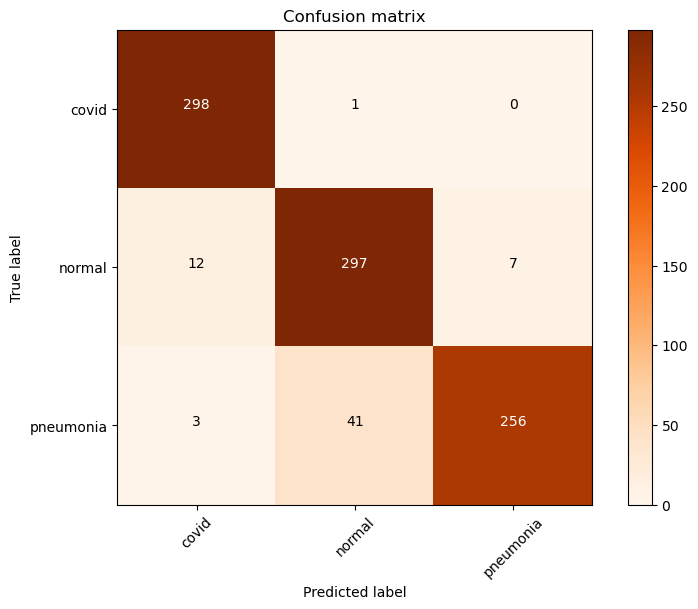

In [20]:
plot_confusion_matrix(model, classes=['covid', 'normal', 'pneumonia'], file_name='confusion_matrix_shallow', save=True, normalize=False,title='Confusion matrix')

29/29 [==============================] - 0s 13ms/step
Normalized confusion matrix


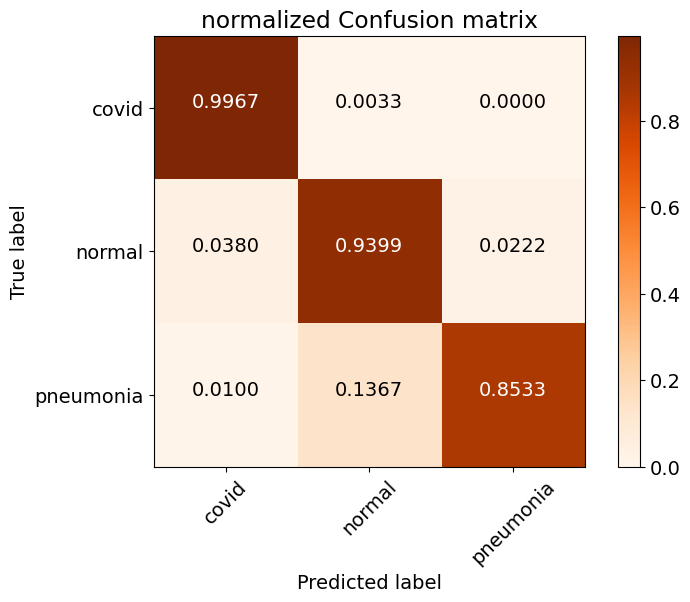

In [21]:
plot_confusion_matrix(model, classes=['covid', 'normal', 'pneumonia'], file_name='confusion_matrix_normalize_shallow', save=True, normalize=True,title='normalized Confusion matrix')

# ResNet50 model

In [22]:
class ResNet50Classifier:

    def __init__(self, activation):
        self.activation = activation
        
        
    def __identity_block(self, X, f, filters, stage, block):

        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        F1, F2, F3 = filters

        X_shortcut = X

        X = tf.keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

        X = tf.keras.layers.Add()([X, X_shortcut])

        return tf.keras.layers.Activation(self.activation)(X)


    def __convolutional_block(self, X, f, filters, stage, block, s=2):

        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'

        F1, F2, F3 = filters

        X_shortcut = X

        X = tf.keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
        X = tf.keras.layers.Activation(self.activation)(X)

        X = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

        X_shortcut = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1')(X_shortcut)
        X_shortcut = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

        X = tf.keras.layers.Add()([X, X_shortcut])

        return tf.keras.layers.Activation(self.activation)(X)


    def __ResNet50(self, input_shape):

        X_input = tf.keras.layers.Input(input_shape)

        X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)
        X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
        X = tf.keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
        X = tf.keras.layers.Activation(self.activation)(X)
        X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

        X = self.__convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
        X = self.__identity_block(X, 3, [64, 64, 256], stage=2, block='b')
        X = self.__identity_block(X, 3, [64, 64, 256], stage=2, block='c')


        X = self.__convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
        X = self.__identity_block(X, 3, [128, 128, 512], stage=3, block='b')
        X = self.__identity_block(X, 3, [128, 128, 512], stage=3, block='c')
        X = self.__identity_block(X, 3, [128, 128, 512], stage=3, block='d')

        X = self.__convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
        X = self.__identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

        X = self.__convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
        X = self.__identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
        X = self.__identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
        X = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

        return tf.keras.models.Model(inputs=X_input, outputs=X, name='ResNet50')


    def create_model(self, input_shape, num_classes):
        base_model = self.__ResNet50(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dense(num_classes, activation='softmax', name='fc1')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='ResNet50_Classifier')

In [23]:
resnet = ResNet50Classifier(activation='relu').create_model(input_shape=(img_height, img_width, NUM_CHANNELS), num_classes=3)

In [24]:
resnet.summary()

Model: "ResNet50_Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 128, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                

In [25]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_resnet.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy'])

In [26]:
resnet_history = resnet.fit(train_ds, epochs = 30, validation_data=test_ds, callbacks=[checkpoint], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/30
115/115 [==============================] - ETA: 0s - loss: 0.8229 - accuracy: 0.7544
Epoch 1: val_accuracy improved from -inf to 0.32787, saving model to best_model_resnet.h5
115/115 [==============================] - 62s 252ms/step - loss: 0.8229 - accuracy: 0.7544 - val_loss: 1.4102 - val_accuracy: 0.3279
Epoch 2/30
115/115 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.8363
Epoch 2: val_accuracy did not improve from 0.32787
115/115 [==============================] - 26s 227ms/step - loss: 0.5864 - accuracy: 0.8363 - val_loss: 1.9875 - val_accuracy: 0.3268
Epoch 3/30
115/115 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.8842
Epoch 3: val_accuracy improved from 0.32787 to 0.40328, saving model to best_model_resnet.h5
115/115 [==============================] - 27s 237ms/step - loss: 0.4025 - accuracy: 0.8842 - val_loss: 1.3007 - val_accuracy: 0.4033
Epoch 4/30
115/115 [==============================] - ETA: 0s - loss: 0.3528

In [27]:
resnet_df = create_history_df('resnet.csv', resnet_history)

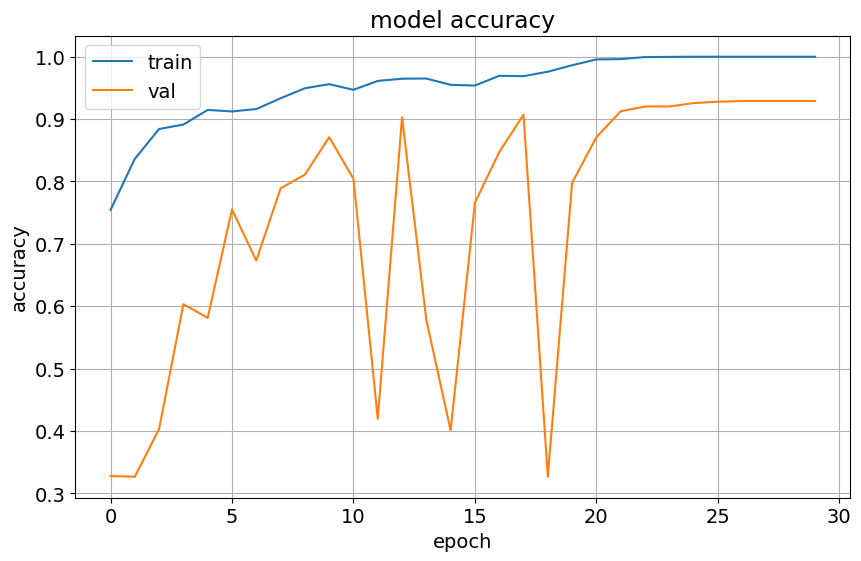

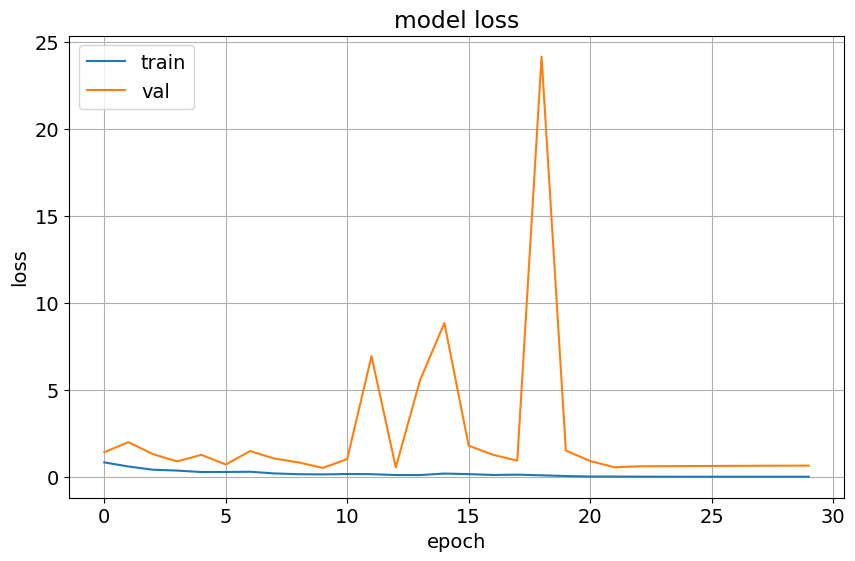

In [28]:
plot_loss_acc(resnet_history)

In [29]:
precision, recall, fscore = calculate_p_r_f1(resnet)

29/29 [==============================] - 3s 66ms/step


In [30]:
resner_report = confusion_matrix_report(model=resnet, report_file_name= 'resnet_classification_report.csv')

29/29 [==============================] - 2s 67ms/step


29/29 [==============================] - 2s 66ms/step
Confusion matrix, without normalization


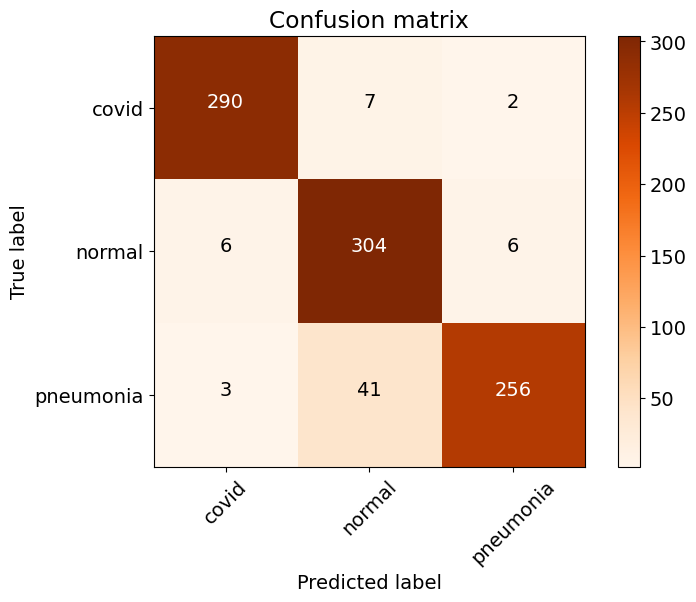

In [31]:
plot_confusion_matrix(model= resnet, classes=['covid', 'normal', 'pneumonia'],file_name='confusion_matrix', save=True, normalize=False,title='Confusion matrix')

29/29 [==============================] - 2s 66ms/step
Normalized confusion matrix


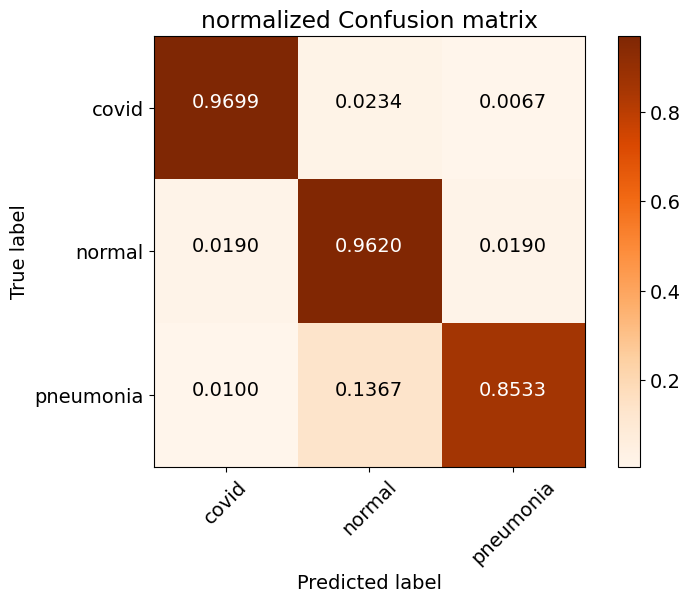

In [32]:
plot_confusion_matrix(model= resnet, classes=['covid', 'normal', 'pneumonia'],file_name='confusion_matrix_normalize', save=True, normalize=True,title='normalized Confusion matrix')

# DensNet model 

In [38]:
class DensNetClassifier:

    def __convblock(self, X, num_channels):
        X_shortcut = X
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.ReLU()(X)
        X = tf.keras.layers.Conv2D(filters=num_channels, kernel_size=(3, 3), padding='same')(X)
        return tf.keras.layers.concatenate([X_shortcut, X], axis=3)

    def __denseblock(self, X, num_convs, num_channels):
        for _ in range(num_convs):
            X = self.__convblock(X, num_channels)
        return X

    def __transitionblock(self, X, num_channels):
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.ReLU()(X)
        X = tf.keras.layers.Conv2D(filters=num_channels, kernel_size=(1, 1), padding='same')(X)
        return tf.keras.layers.AveragePooling2D(pool_size=2, strides=2)(X)

    def __DensNet(self, input_shape, num_channels, growth_rate, arch):
        X_input = tf.keras.layers.Input(input_shape)
        X = tf.keras.layers.Conv2D(num_channels, kernel_size=7, strides=2, padding='same')(X_input)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.ReLU()(X)
        X = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(X)
        for i, num_convs in enumerate(arch):
            X = self.__denseblock(X, num_convs, growth_rate)
            num_channels += num_convs * growth_rate
            if i != len(arch) - 1:
                num_channels //= 2
                X = self.__transitionblock(X, num_channels)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.ReLU()(X)
        X = tf.keras.layers.GlobalAveragePooling2D()(X)
        return tf.keras.models.Model(inputs=X_input, outputs=X, name='DenseNet')

    def create_model(self, input_shape, num_classes):
        base_model = self.__DensNet(input_shape, num_channels=32, growth_rate=32, arch=(4, 4, 4, 4))
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dense(num_classes, activation='softmax', name='fc1')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='DenseNet_Classifier')

In [39]:
dense_model = DensNetClassifier().create_model(input_shape=(img_height, img_width, NUM_CHANNELS), num_classes=3)

In [40]:
dense_model.summary()

Model: "DenseNet_Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 128, 128, 32  4736        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_25 (BatchN  (None, 128, 128, 32  128        ['conv2d_24[0][0]']              
 ormalization)                  )                                               

In [41]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_dense.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

dense_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [42]:
dense_history = dense_model.fit(train_ds, epochs = 30, validation_data=test_ds, callbacks=[checkpoint], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/30
114/115 [============================>.] - ETA: 0s - loss: 0.5078 - accuracy: 0.8177
Epoch 1: val_accuracy improved from -inf to 0.29180, saving model to best_model_dense.h5
115/115 [==============================] - 21s 70ms/step - loss: 0.5084 - accuracy: 0.8178 - val_loss: 1.3357 - val_accuracy: 0.2918
Epoch 2/30
114/115 [============================>.] - ETA: 0s - loss: 0.2891 - accuracy: 0.9101
Epoch 2: val_accuracy improved from 0.29180 to 0.37049, saving model to best_model_dense.h5
115/115 [==============================] - 8s 67ms/step - loss: 0.2903 - accuracy: 0.9098 - val_loss: 1.6292 - val_accuracy: 0.3705
Epoch 3/30
114/115 [============================>.] - ETA: 0s - loss: 0.2304 - accuracy: 0.9285
Epoch 3: val_accuracy did not improve from 0.37049
115/115 [==============================] - 8s 70ms/step - loss: 0.2318 - accuracy: 0.9281 - val_loss: 1.9914 - val_accuracy: 0.3454
Epoch 4/30
114/115 [============================>.] - ETA: 0s - loss: 0.1984 - accu

In [43]:
densenet_df = create_history_df('densenet.csv', dense_history)

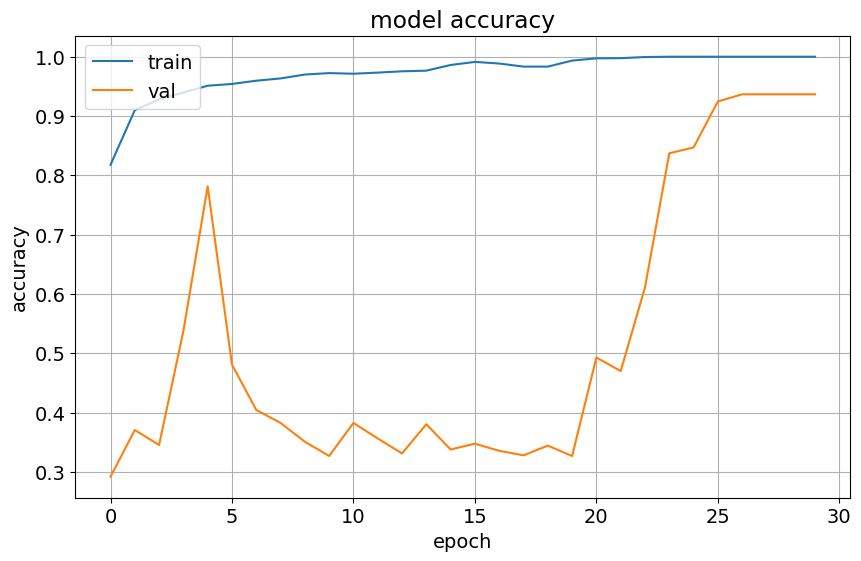

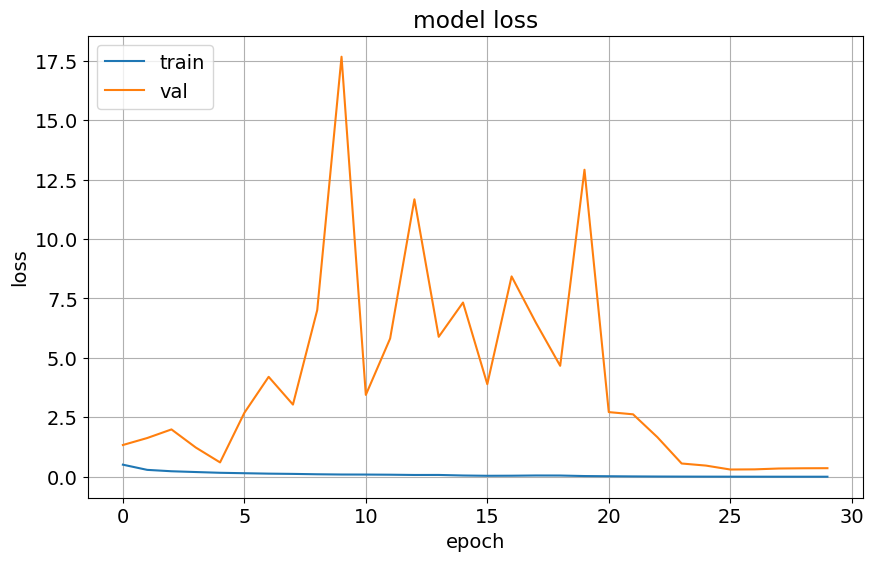

In [44]:
plot_loss_acc(dense_history)

In [45]:
precision, recall, fscore = calculate_p_r_f1(dense_model)
resner_report = confusion_matrix_report(dense_model, report_file_name= 'resnet_classification_report.csv')

29/29 [==============================] - 1s 21ms/step


29/29 [==============================] - 1s 21ms/step
Confusion matrix, without normalization


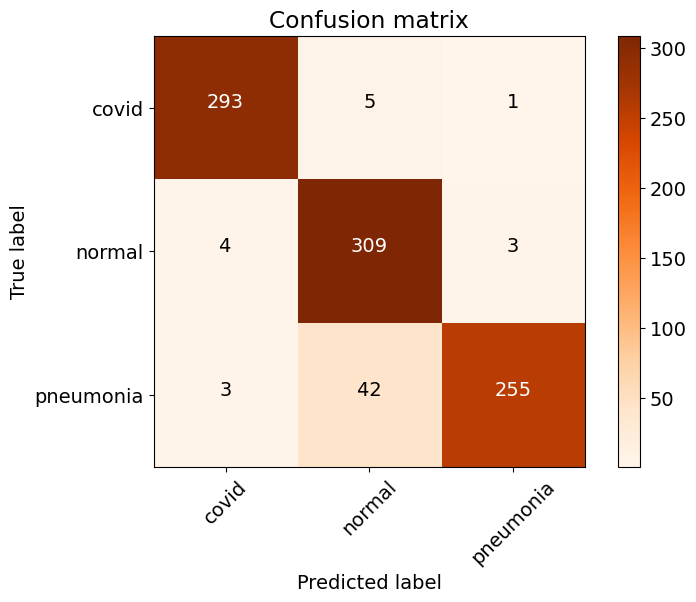

In [46]:
plot_confusion_matrix(dense_model, classes=['covid', 'normal', 'pneumonia'], file_name='confusion_matrix', save=True, normalize=False,title='Confusion matrix')

29/29 [==============================] - 1s 21ms/step
Normalized confusion matrix


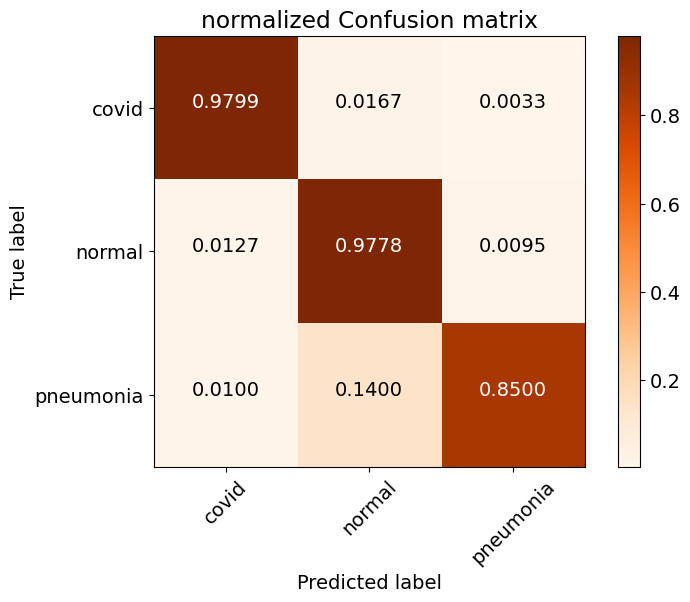

In [47]:
plot_confusion_matrix(dense_model, classes=['covid', 'normal', 'pneumonia'], file_name='confusion_matrix_normalize', save=True, normalize=True,title='normalized Confusion matrix')

# Part Two: Evaluation with pretrained models

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
directory = '/kaggle/input/moones-hda/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
batch_size = 32
img_height = 256
img_width = 256
NUM_CHANNELS = 3

In [3]:
def test_data_augmentation(image, label):
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, [img_height, img_width])
    return image, label

In [4]:
def create_dataset(directory, batch_size):    
    test_ds = tf.keras.utils.image_dataset_from_directory(directory,
      labels='inferred',
      label_mode='categorical',
      color_mode='rgb',
      batch_size=batch_size,
      seed=42,
      validation_split=0.2,
      subset='validation',
      crop_to_aspect_ratio=False)

    test_ds = test_ds.map(test_data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.cache()
    test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return test_ds

In [5]:
test_ds = create_dataset(directory, batch_size)

Found 4575 files belonging to 3 classes.
Using 915 files for validation.


In [6]:
def plot_image(X_input, labels):
    plt.imshow(X_input, cmap=plt.cm.gray_r, interpolation='nearest')
    print("LABEL: %s" % labels)
    plt.show()
    return

def label_decoder(label):
    if label[0] == 1:
        return 'Covid'
    if label[1] == 1:
        return 'Normal'
    if label[2] == 1:
        return 'Pneumonia'

LABEL: Pneumonia


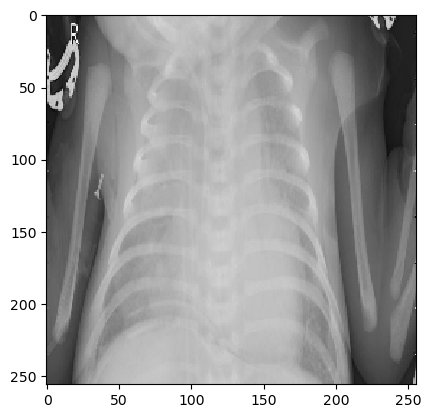

LABEL: Normal


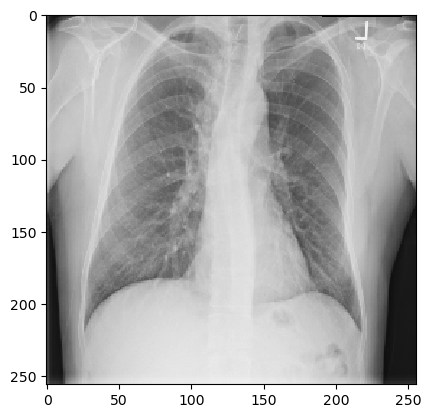

LABEL: Covid


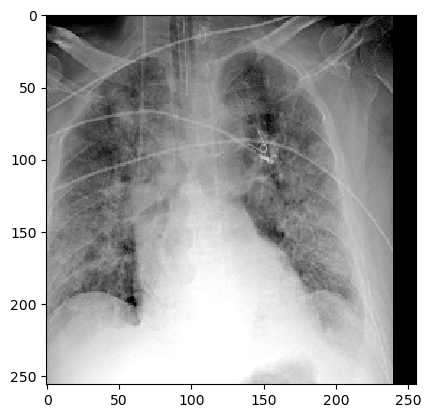

LABEL: Normal


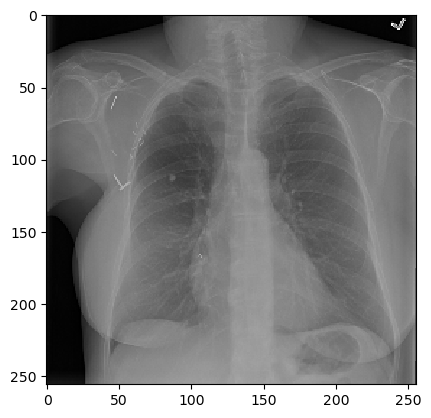

LABEL: Normal


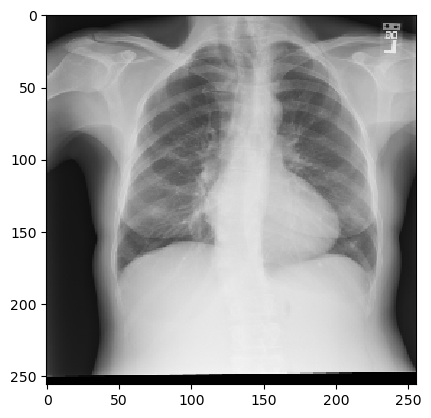

In [7]:
indices = np.random.randint(0, 32, (5,))
ds = test_ds.take(1).get_single_element()
for index in indices:
    image = ds[0][index]
    label = label_decoder(ds[1][index])
    plot_image(image, label)

In [8]:
test_steps = int(tf.data.experimental.cardinality(test_ds).numpy())

In [9]:
def load_pretrained_model(model_name):
    return tf.keras.models.load_model('/kaggle/input/moones-hda/best_model_' + model_name + '.h5')

In [10]:
shallow = load_pretrained_model('shallow')
resnet = load_pretrained_model('resnet')
densnet = load_pretrained_model('dense')

In [11]:
shallow_evaluate = shallow.evaluate(test_ds, verbose=2, steps=test_steps, return_dict=True)
for name, value in shallow_evaluate.items():
    print(f"{name}: {value:.4f}")

29/29 - 14s - loss: 0.2283 - accuracy: 0.9366 - 14s/epoch - 499ms/step
loss: 0.2283
accuracy: 0.9366


In [12]:
resnet_evaluate = resnet.evaluate(test_ds, verbose=2, steps=test_steps, return_dict=True)
for name, value in resnet_evaluate.items():
    print(f"{name}: {value:.4f}")

29/29 - 4s - loss: 0.6257 - accuracy: 0.9290 - 4s/epoch - 123ms/step
loss: 0.6257
accuracy: 0.9290


In [13]:
densnet_evaluate = densnet.evaluate(test_ds, verbose=2, steps=test_steps, return_dict=True)
for name, value in densnet_evaluate.items():
    print(f"{name}: {value:.4f}")

29/29 - 1s - loss: 0.3112 - accuracy: 0.9366 - 1s/epoch - 48ms/step
loss: 0.3112
accuracy: 0.9366
